In [20]:
from warnings import filterwarnings

filterwarnings('ignore')

import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from PyEMD import EMD,CEEMDAN, EEMD
from sklearn.feature_selection import mutual_info_regression


from modules.data_fetcher import download_historical_data

In [21]:
SYMBOL= 'BTC-USDT'

df = download_historical_data(SYMBOL,'1hour').iloc[-3000:]
df["Return"] = df.Close.pct_change()
df.dropna(inplace=True)
print(df.shape)
df.head()

(2999, 8)


,Timestamp,Open,Close,High,Low,Amount,Volume,Return
Date,,,,,,,,
2022-10-25 10:00:00,1.666685e+09,19306.7,19295.5,19323.5,19269.6,281.055517,5.425897e+06,-0.000554
2022-10-25 11:00:00,1.666688e+09,19295.4,19266.3,19296.1,19257.0,291.026014,5.610201e+06,-0.001513
2022-10-25 12:00:00,1.666692e+09,19266.3,19296.2,19298.9,19237.5,259.489626,5.001039e+06,0.001552
2022-10-25 13:00:00,1.666696e+09,19296.4,19301.3,19328.9,19275.6,205.836094,3.972412e+06,0.000264
2022-10-25 14:00:00,1.666699e+09,19301.3,19325.5,19343.7,19260.0,297.347957,5.737919e+06,0.001254


In [22]:
def emd(signal):
    emd = EMD(DTYPE=np.float16, spline_kind='cubic')#CEEMDAN() 
    imfs = emd(signal.values)
    
    t = [i for i in range(len(signal))]
    N = imfs.shape[0]
    fig, axs = plt.subplots(N + 1, 1, figsize=(25,11))
    axs[0].plot(t, signal)
    axs[0].set_title('Original Signal')
    for n, imf in enumerate(imfs):
        axs[n+1].plot(t, imf)
        axs[n+1].set_title(f'IMF {n}')
    
    return imfs

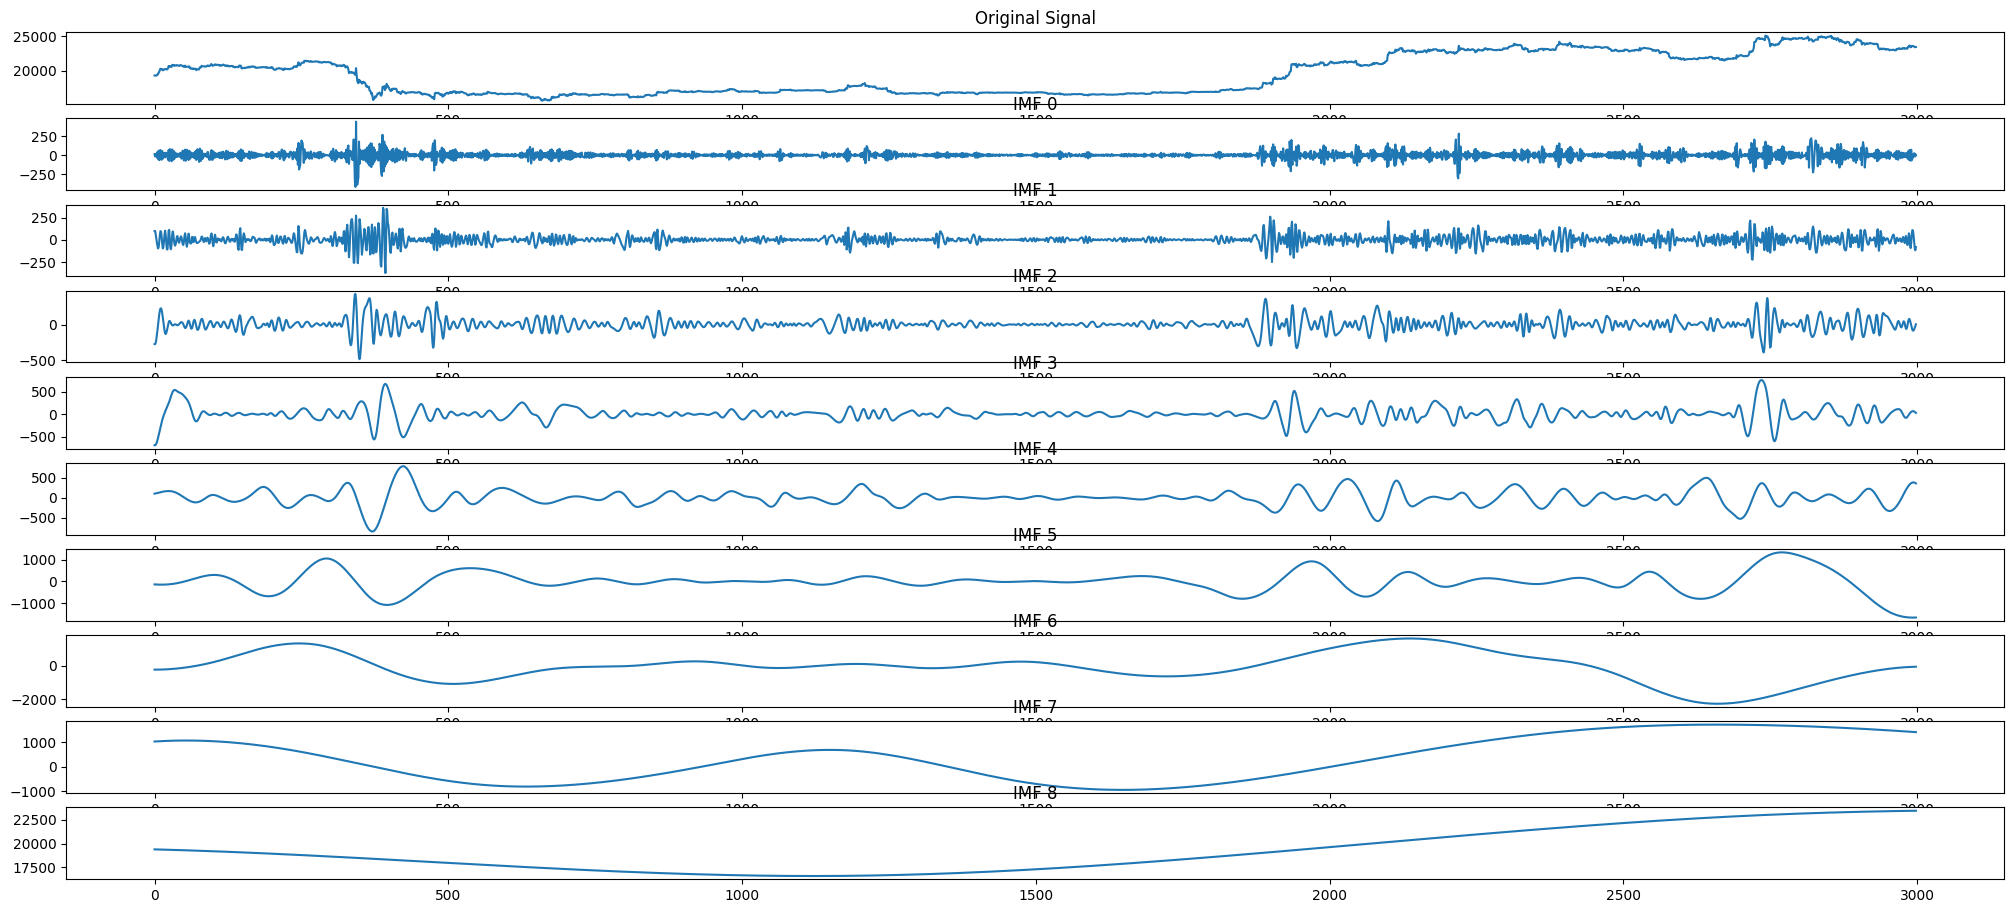

In [23]:
imfs = emd(df["Close"])

In [24]:
def phase_spectrum(imfs):
    imfs_p = []
    fig, axs = plt.subplots(len(imfs), 1, figsize=(25,11))
    for i, imf in enumerate(imfs):
        trans =  np.fft.fft(imf)
        imf_p = np.arctan(trans.imag / trans.real)
        
        imfs_p.append(imf_p)
        
        axs[i].plot(imf_p, 'o')
        axs[i].set_title(f'IMF {i}')
        
    return imfs_p

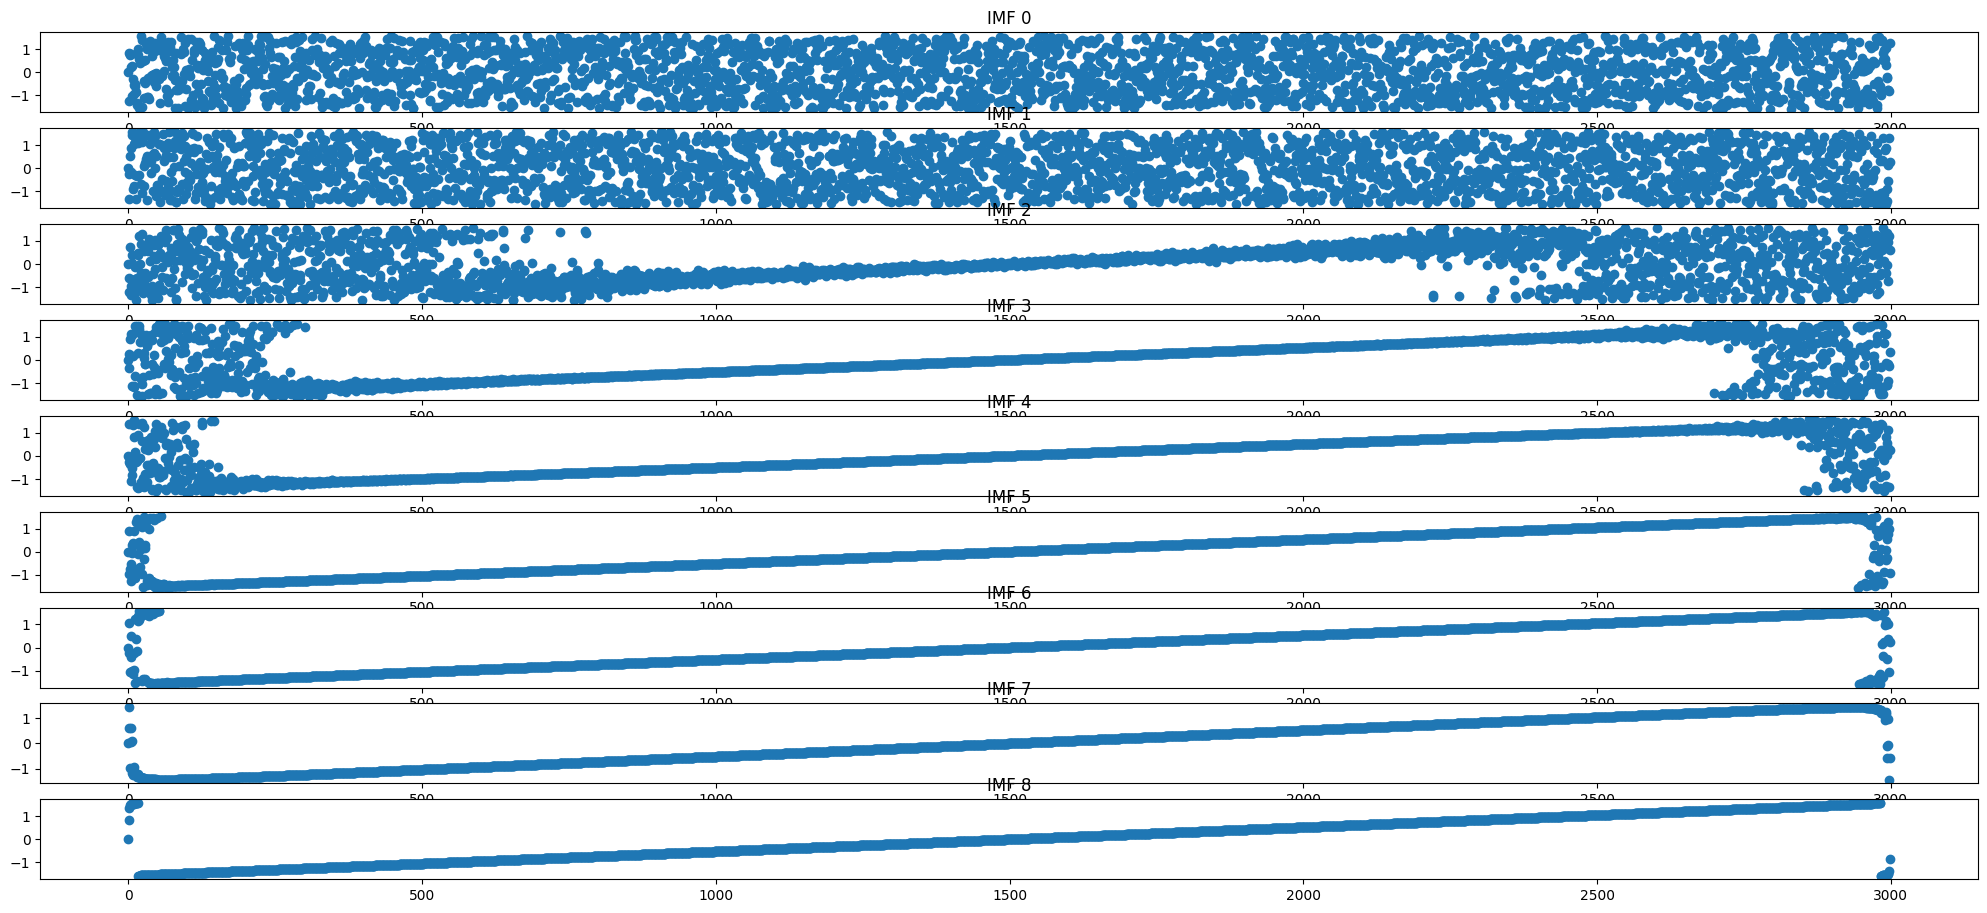

In [25]:
imfs_p = phase_spectrum(imfs)

In [26]:
def phase_mi(phases):
    mis = []
    for i in range(len(phases)-1):
        mis.append(mutual_info_regression(phases[i].reshape(-1, 1), phases[i+1])[0])
        
    return np.array(mis)
mis = phase_mi(imfs_p)

def divide_signal(signal, imfs, mis, cutoff=0.75):
    cut_point = np.where(mis > cutoff)[0][0]
    stochastic_component = np.sum(imfs[:cut_point], axis=0)
    deterministic_component = np.sum(imfs[cut_point:], axis=0)
    
    t = [i for i in range(len(signal))]
    
    fig, axs = plt.subplots(3, 1, figsize=(25,11))
    axs[0].plot(t, signal.values)
    axs[0].set_title('Original Signal')
    
    axs[1].plot(t, stochastic_component)
    axs[1].set_title('Stochastic Component')
    
    axs[2].plot(t, deterministic_component)
    axs[2].set_title('Deterministic Component')
    
    return stochastic_component, deterministic_component

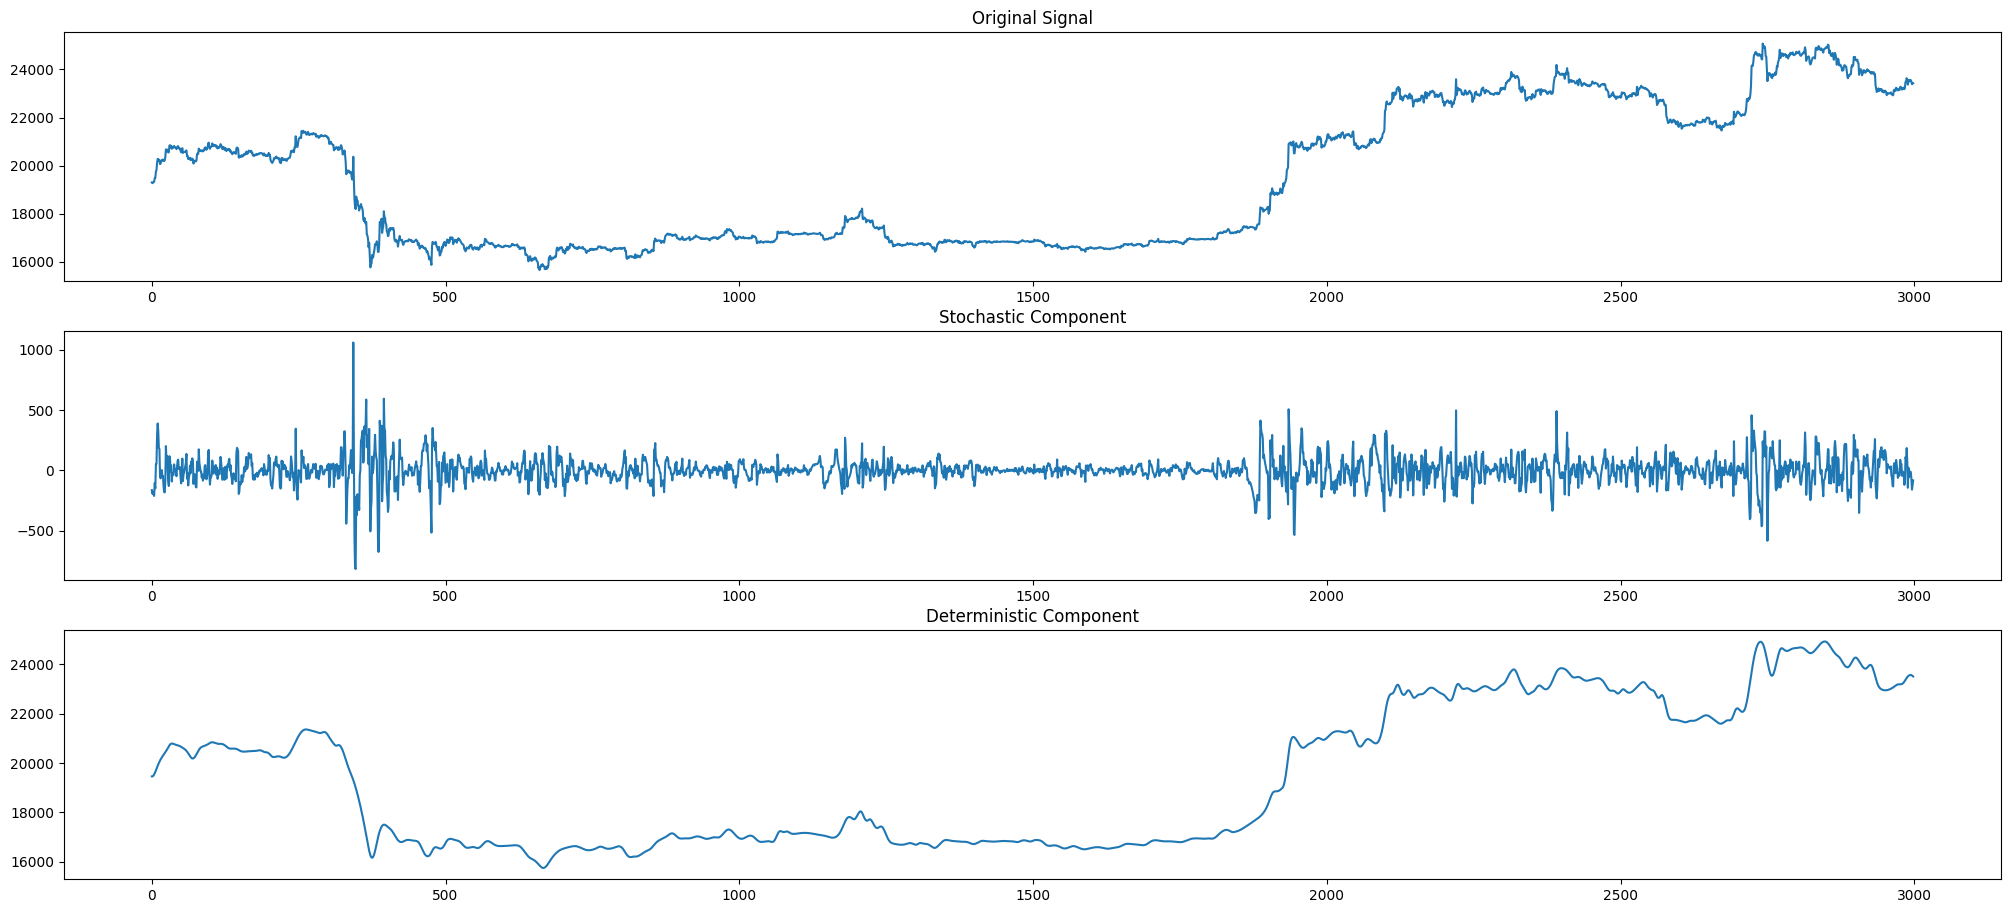

In [27]:
stochastic_component, deterministic_component = divide_signal(df["Close"], imfs, mis,cutoff=0.96)

In [28]:
df['deterministic_component'] = deterministic_component
df['stochastic_component'] = stochastic_component
df['deterministic_component_diff'] = df['deterministic_component'].diff()
df.dropna(inplace=True)

fig = make_subplots(
    rows=1, cols=1
)

fig.add_trace(
    go.Scatter(
        name="Raw data",
        x=df.index,
        y=df["Close"],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        name="Deterministic data",
         x=df.index,
         y=df["deterministic_component"],
    ),
    row=1,
    col=1,
)
fig.update_layout(
    xaxis_rangeslider_visible=False,
    showlegend=True,
    title_text="Fourrier extrapolation (prediction)",
)

# Signal generation

In [30]:
df['deterministic_component_diff'] = df.deterministic_component.diff(1)
df.dropna(inplace=True)

In [31]:
def derivative_transition(set_of_rows)->str:
    return (1 if set_of_rows[0]<0 and set_of_rows[-1]>0 else
            -1 if set_of_rows[0]>0 and set_of_rows[-1]<0 else 0)


df['Signal'] = df["deterministic_component_diff"].rolling(2).apply(derivative_transition)

df.dropna(inplace=True)
df.head()

,Timestamp,Open,Close,High,Low,Amount,Volume,Return,deterministic_component,stochastic_component,deterministic_component_diff,Signal
Date,,,,,,,,,,,,
2022-10-25 13:00:00,1.666696e+09,19296.4,19301.3,19328.9,19275.6,205.836094,3.972412e+06,0.000264,19499.512190,-198.212190,26.804248,0.0
2022-10-25 14:00:00,1.666699e+09,19301.3,19325.5,19343.7,19260.0,297.347957,5.737919e+06,0.001254,19537.261226,-211.761226,37.749036,0.0
2022-10-25 15:00:00,1.666703e+09,19325.1,19479.0,19525.1,19324.0,1045.330758,2.030455e+07,0.007943,19584.010983,-105.010983,46.749757,0.0
2022-10-25 16:00:00,1.666706e+09,19479.1,19488.9,19544.9,19444.6,702.107078,1.368342e+07,0.000508,19637.817395,-148.917395,53.806412,0.0
2022-10-25 17:00:00,1.666710e+09,19488.6,19748.3,19818.0,19484.4,1753.289388,3.448414e+07,0.013310,19696.736396,51.563604,58.919001,0.0


In [32]:
fig = make_subplots(
    rows=1, cols=1
)

fig.add_trace(
    go.Scatter(
        name="Raw data",
        x=df.index,
        y=df["Close"],
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Scatter(
        name="Deterministic component",
         x=df.index,
         y=df["deterministic_component"],
    ),
    row=1,
    col=1,
)

df_buy = df.loc[df['Signal']==1]
fig.add_trace(
    go.Scatter(
        name="Buy signal",
        mode='markers',
         x=df_buy.index,
         y=df_buy["Close"],
         marker=dict(
            color='Green',
            symbol="triangle-up",
            size=10,
        ),
    ),
    row=1,
    col=1,
)

df_sell = df.loc[df['Signal']==-1]
fig.add_trace(
    go.Scatter(
        name="Sell signal",
        mode='markers',
         x=df_sell.index,
         y=df_sell["Close"],
         marker=dict(
            color='Red',
            symbol="triangle-down",
            size=10,
        ),
    ),
    row=1,
    col=1,
)
fig.update_layout(
    xaxis_rangeslider_visible=False,
    showlegend=True,
    title_text="Fourrier extrapolation (prediction)",
)